In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
engine

Engine(sqlite:///hawaii.sqlite)

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x192a924f760>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [10]:
# Find the most recent date in the data set.
recentDate = session.query(func.max(Measurement.date)).first()
print(recentDate[0])

2017-08-23


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
dateRange = dt.datetime.strptime(recentDate[0], '%Y-%m-%d') - dt.timedelta(days=365)
dateRange

# Perform a query to retrieve the data and precipitation scores
rows = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= dateRange).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(rows, columns=['Date', 'Precipitation'])
df.loc[:,'Precipitation'] =  df['Precipitation'].fillna(0)
df.set_index('Date', inplace=True)
# Sort the dataframe by date
df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df


,Precipitation
Date,
2016-08-24,0.08
2016-08-24,0.00
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


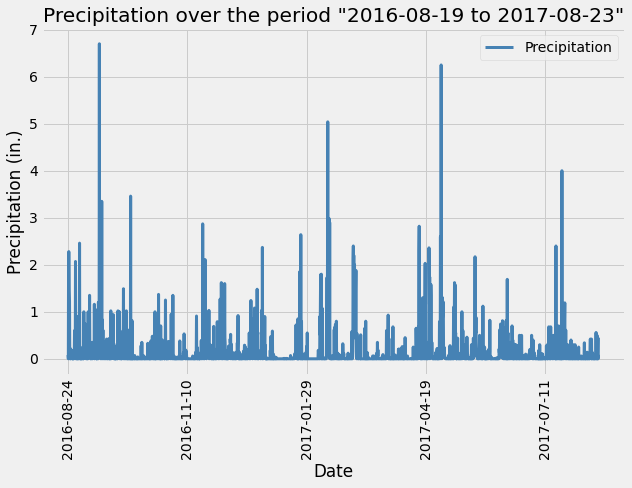

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (9, 7))
df.plot(kind='line', ax = ax, x_compat = True, linewidth=3, color='steelblue')

ax.set_ylabel('Precipitation (in.)')
ax.set_title('Precipitation over the period "2016-08-19 to 2017-08-23"')
ax.fill()
plt.xticks(rotation="vertical")
#plt.savefig("Images/precipitation.png")

plt.tight_layout()
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
station = session.query(func.count(Station.station))
stationCount = station[0][0]
print(f"Total number of stations = {stationCount}")

Total number of stations = 9


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

results = session.query(Measurement.station,Station.name, func.count(Measurement.station))\
        .filter(Measurement.station == Station.station)\
        .group_by(Measurement.station)\
        .order_by(func.count(Measurement.station).desc()).all()
results

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
        .filter(Measurement.station == results[0][0]).first()

('USC00519281', 54.0, 85.0, 71.66378066378067)

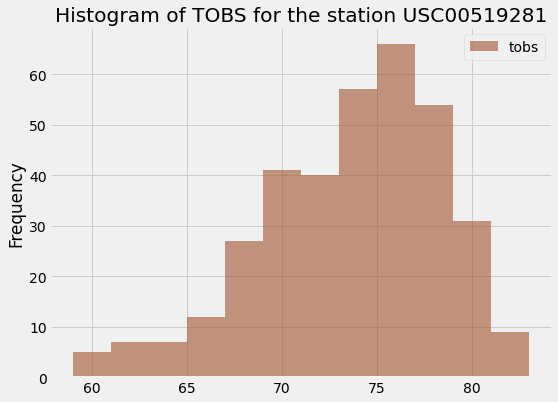

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recentDate = session.query(func.max(Measurement.date)).filter(Measurement.station == results[0][0]).first()

dateRange = dt.datetime.strptime(recentDate[0], '%Y-%m-%d') - dt.timedelta(days=365)
dateRange

# Perform a query to retrieve the data and precipitation scores
rows = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == results[0][0]).filter(Measurement.date >= dateRange).all()
df = pd.DataFrame(rows)
df.plot(kind='hist',bins=12, title = 'Histogram of TOBS for the station '+results[0][0], xlabel = 'Temperature', figsize=(8,6), color='sienna', alpha=0.6)

plt.ylabel = 'Frequency'
plt.show()


# Close session

In [21]:
# Close Session
session.close()